In [1]:
import supervisely_lib as sly
import cv2
from Layer import Layer
import layers
import os.path as osp
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
crop_settings = {
  "action": "crop",
  "src": ["$data1"],
  "dst": "$data2",
  "settings": {
    "sides": {
      "top":"30%",
      "left":"100px",
      "right":"100px",
      "bottom":"0px"
    }
  }
}
flip_settings = {
  "action": "flip",
  "src": ["$data1"],
  "dst": "$data2",
  "settings": {
    "axis": "vertical"
  }
}
inst_crop_settings = {
  "action": "instances_crop",
  "src": [
    "$sample"
  ],
  "dst": "$sample1",
  "settings": {
    "classes": [
      "Car"
    ],
    "pad": {
      "sides": {
        "top": "10%",
        "left": "10%",
        "right": "10%",
        "bottom": "10%"
      }
    }
  }
}

In [3]:
crop_layer = layers.processing.CropLayer.CropLayer(crop_settings)
flip_layer = layers.processing.FlipLayer.FlipLayer(flip_settings)
inst_crop_layer = layers.processing.InstancesCrop.InstancesCropLayer(inst_crop_settings)

In [4]:
task_paths = sly.TaskPaths()
project_dir = task_paths.project_dir
project_meta = sly.ProjectMeta.from_dir(project_dir)

In [5]:
fs = sly.ProjectFS.from_disk(*sly.ProjectFS.split_dir_project(project_dir))
out_pr_structure = sly.ProjectStructure('project_augmentations')

In [6]:
for sample_info in fs:
    sample_data = sample_info.ia_data
    dt = {
        'src_img_path': sample_info.img_path,
        'ann_img_path': sample_info.ann_path,
        **sample_data
    }
    out_pr_structure.add_item(sample_info.ds_name, sample_info.image_name, dt)

In [7]:
out_pr_fs = sly.ProjectFS(task_paths.results_dir, out_pr_structure)
out_pr_fs.make_dirs()

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


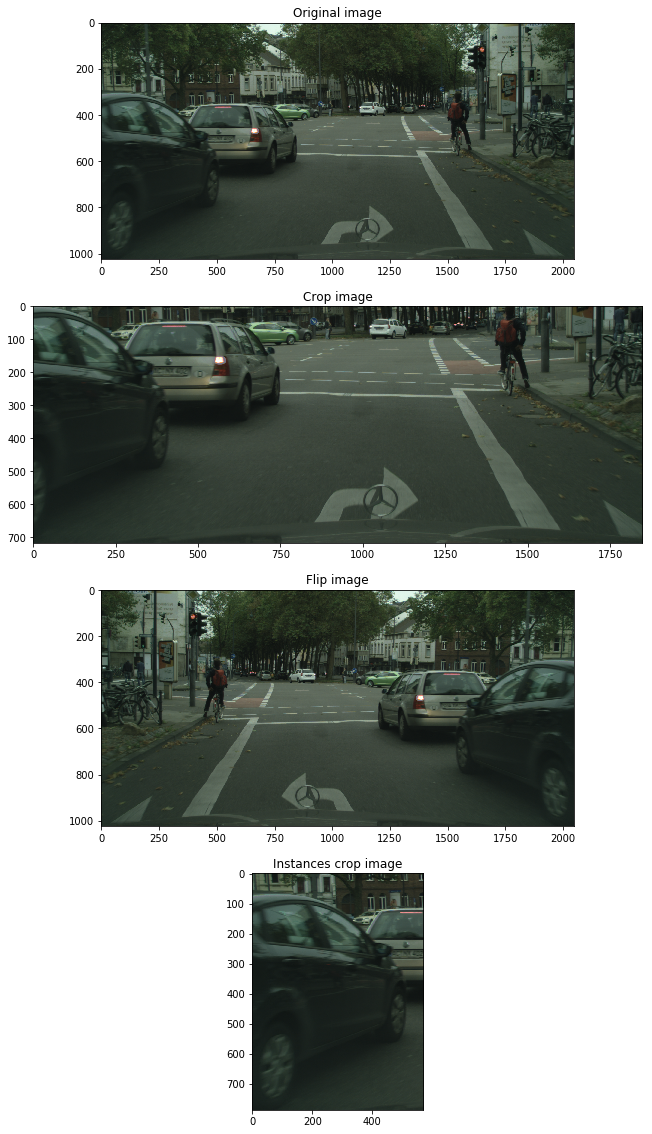

In [8]:
for s in out_pr_fs:
    plt.figure(figsize=(20, 20))
    sly.copy_file(s.ia_data['src_img_path'], s.img_path)
    sly.copy_file(s.ia_data['ann_img_path'], s.ann_path)
    img_name, img_ext = osp.splitext(s.img_path)
    img_desc = sly.ImageDescriptor(s)
    ax = plt.subplot(4, 1, 1)
    ax.set_title('Original image')
    plt.imshow(img_desc.read_image())
    ann_name, ann_ext = osp.splitext(s.ann_path)
    ann_packed = sly.json_load(s.ann_path)
    ann = sly.Annotation.from_packed(ann_packed, project_meta)
    data_el = (img_desc, ann)
    cropped_img = crop_layer.process(data_el)
    flipped_img = flip_layer.process(data_el)
    inst_crop_img = inst_crop_layer.process(data_el)
    for new_img_desc, new_ann in cropped_img:
        new_img_desc.write_image_local(img_name + "_crop" + img_ext)
        sly.json_dump(new_ann.pack(), ann_name + "_crop" + ann_ext)
        ax = plt.subplot(4, 1, 2)
        ax.set_title('Crop image')
        plt.imshow(new_img_desc.read_image())
    for new_img_desc, new_ann in flipped_img:
        new_img_desc.write_image_local(img_name + "_flip" + img_ext)
        sly.json_dump(new_ann.pack(), ann_name + "_flip" + ann_ext)
        ax = plt.subplot(4, 1, 3)
        ax.set_title('Flip image')
        plt.imshow(new_img_desc.read_image())
    for new_img_desc, new_ann in inst_crop_img:
        new_img_desc.write_image_local(img_name + "_inst_crop" + img_ext)
        sly.json_dump(new_ann.pack(), ann_name + "_inst_crop" + ann_ext)
        ax = plt.subplot(4, 1, 4)
        ax.set_title('Instances crop image')
        plt.imshow(new_img_desc.read_image())
    plt.show()